In [1]:
import os

ROOT="/content/drive/MyDrive/NLP NOTES/NLP notes"

os.chdir(ROOT)

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
def get_plot(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[f"val_{metric}"])
  plt.xlabel("Epochs ->>")
  plt.ylabel(f"{metric} ->>")
  plt.legend([metric, f"val_{metric}"])

In [4]:
dataset_name="imdb_reviews"
dataset,info=tfds.load(dataset_name,with_info=True , as_supervised=True)
train_ds,test_ds=dataset["train"],dataset["test"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR2D2JI/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR2D2JI/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteR2D2JI/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
for example, label in train_ds.take(1):
  print(f"test_example: \n{example.numpy()} \n")
  print(f"label: {label.numpy()}")

test_example: 
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." 

label: 0


In [6]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [7]:
class Config:
  BUFFER_SIZE = 10000
  BATCH_SIZE = 64
  VOCAB_SIZE = 1000
  OUTPUT_DIM = 64
  EPOCHS = 10 
  BASE_LOG_DIR = "base_log_dir"
  TRAINED_MODEL_DIR = os.path.join(BASE_LOG_DIR, "models")
  CKPT_DIR = os.path.join(BASE_LOG_DIR, "checkpoints")
  TB_ROOT_LOG_DIR = os.path.join(BASE_LOG_DIR, "tb_log_dir")

In [8]:
config=Config()

In [9]:
config.BUFFER_SIZE#how much size should keep in memory before passing to training

10000

In [10]:
# shuffling and batching of the train dataset

train_ds = train_ds.shuffle(config.BUFFER_SIZE).batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)#te doesnt need shuffle
#prefecth-how much data jeep ready in memory for next iteration

In [14]:
for example, label in train_ds.take(1):
  print(f"test_example: \n{example.numpy()[:3]} \n")
  print(f"label: {label.numpy()[:3]}")

test_example: 
[b"I was unlucky enough to have seen this at the Sidewalk Film Festival. Sidewalk as a whole was a disappointment and this movie was the final nail in the coffin. Being a devout fan of Lewis Carroll's 'Alice' books I was very excited about this movie's premier, which only made it that much more uncomfortable to watch. Normally I'm enthusiastic about modern re-tellings if they are treated well. Usually it's interesting to see the parallels between the past and present within a familiar story. Unfortunately this movie was less of a modern retelling and more of a pop culture perversion. The adaptation of the original's characters seemed juvenile and usually proved to be horribly annoying. It probably didn't help that the actors weren't very good either. Most performances were ridiculously over the top, which I assume was either due to bad direction or an effort to make up for a bad script. I did not laugh once through out the duration of the film. All of the jokes were outd

In [15]:
# text encoder 

# keep the data as it is without custom standardisation
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=config.VOCAB_SIZE)

# adapt to change only on text data
encoder.adapt(train_ds.map(lambda text, label: text))


## text, label ## <--- train data is arranged

In [16]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [17]:
print("text examples\n", example.numpy()[:3])

text examples
 [b"I was unlucky enough to have seen this at the Sidewalk Film Festival. Sidewalk as a whole was a disappointment and this movie was the final nail in the coffin. Being a devout fan of Lewis Carroll's 'Alice' books I was very excited about this movie's premier, which only made it that much more uncomfortable to watch. Normally I'm enthusiastic about modern re-tellings if they are treated well. Usually it's interesting to see the parallels between the past and present within a familiar story. Unfortunately this movie was less of a modern retelling and more of a pop culture perversion. The adaptation of the original's characters seemed juvenile and usually proved to be horribly annoying. It probably didn't help that the actors weren't very good either. Most performances were ridiculously over the top, which I assume was either due to bad direction or an effort to make up for a bad script. I did not laugh once through out the duration of the film. All of the jokes were outd

In [18]:
encoder_example = encoder(example)[:3].numpy()
encoder_example

array([[ 10,  14,   1, ...,   0,   0,   0],
       [ 15,  10, 373, ...,   0,   0,   0],
       [  1,  44,   1, ...,   0,   0,   0]])

In [19]:
# model for BiRNN

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(encoder.get_vocabulary()),
    output_dim=config.OUTPUT_DIM,
    mask_zero=True # use masking to handle the variable seq lengths example <sos>, <pad>, <eod>
)

In [20]:
LAYERS = [
          encoder,
          embedding_layer,
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
          tf.keras.layers.Dense(64, activation="relu"),
          tf.keras.layers.Dense(1)
]

In [21]:
model = tf.keras.Sequential(LAYERS)

In [23]:
[layer.supports_masking for layer in model.layers]#Masking allows us to handle variable length inputs in RNNs. 
#Now that all samples have a uniform length, the model must be informed that
# some part of the data is actually padding and should be ignored. That mechanism is maskin

[False, True, True, True, True]

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [26]:
import time

def callbacks(base_dir="."):
  # tb callbacks

  base_log_dir = config.TB_ROOT_LOG_DIR
  unqiue_log = time.asctime().replace(" ","_").replace(":", "")
  tb_log_dir = os.path.join(base_log_dir, unqiue_log)
  os.makedirs(tb_log_dir, exist_ok=True)

  tb_cb = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir)

  # ckpt callbacks
  ckpt_file = os.path.join(config.CKPT_DIR, "model")
  os.makedirs(config.CKPT_DIR, exist_ok=True)

  ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
      filepath = ckpt_file, 
      save_best_only = True)
  
  callback_list = [tb_cb, ckpt_cb]

  return callback_list

In [27]:
callback_list = callbacks()

In [28]:
history = model.fit(train_ds, 
                    epochs=config.EPOCHS, 
                    validation_data=test_ds, 
                    validation_steps=30, 
                    callbacks=callback_list)

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.5857

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 67s 145ms/step - loss: 0.6283 - accuracy: 0.5857 - val_loss: 0.4729 - val_accuracy: 0.7667
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8167

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 55s 141ms/step - loss: 0.4021 - accuracy: 0.8167 - val_loss: 0.3666 - val_accuracy: 0.8307
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8508

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 55s 140ms/step - loss: 0.3426 - accuracy: 0.8508 - val_loss: 0.3411 - val_accuracy: 0.8531
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8598

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 55s 140ms/step - loss: 0.3224 - accuracy: 0.8598 - val_loss: 0.3359 - val_accuracy: 0.8573
Epoch 5/10
391/391 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8646

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 56s 141ms/step - loss: 0.3143 - accuracy: 0.8646 - val_loss: 0.3257 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 34s 85ms/step - loss: 0.3125 - accuracy: 0.8642 - val_loss: 0.3297 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8686

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 57s 144ms/step - loss: 0.3064 - accuracy: 0.8686 - val_loss: 0.3228 - val_accuracy: 0.8521
Epoch 8/10
391/391 [==============================] - 34s 87ms/step - loss: 0.3002 - accuracy: 0.8732 - val_loss: 0.3495 - val_accuracy: 0.8323
Epoch 9/10
391/391 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8692

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 55s 141ms/step - loss: 0.3009 - accuracy: 0.8692 - val_loss: 0.3206 - val_accuracy: 0.8604
Epoch 10/10
391/391 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.8721

INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


INFO:tensorflow:Assets written to: base_log_dir/checkpoints/model/assets


391/391 [==============================] - 56s 142ms/step - loss: 0.2977 - accuracy: 0.8721 - val_loss: 0.3176 - val_accuracy: 0.8583


In [29]:
test_loss, test_acc = model.evaluate(test_ds)

test_loss, test_acc

391/391 [==============================] - 25s 63ms/step - loss: 0.3138 - accuracy: 0.8585


(0.3137858211994171, 0.858519971370697)

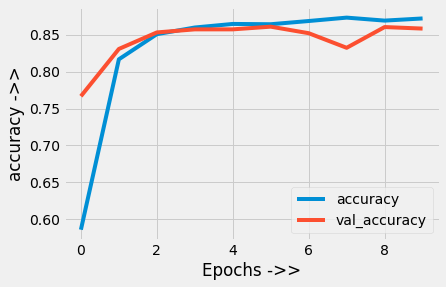

In [30]:
get_plot(history=history, metric="accuracy")

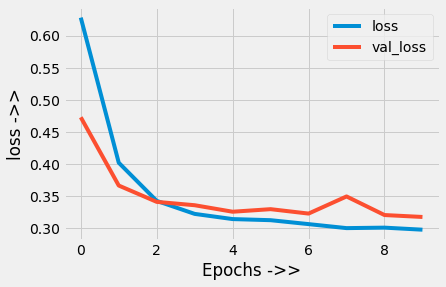

In [31]:
get_plot(history=history, metric="loss")

In [33]:
sample = ("The movie was cool. The animation and the graphics were of this world. I would recommend this movie")

In [34]:
def get_score_and_sentiment(model, sample_text):
    pred = model.predict(np.array([sample_text]))
    score = pred[0][0]
    if score >=0:
        print(f"result: positive sentiment with score: {score}")
    else:
        print(f"result: negitive sentiment with score: {score}")

In [35]:
get_score_and_sentiment(model, sample)

result: positive sentiment with score: 0.6335510611534119


In [36]:
sample_text = ("The movie was crap. The animation and the graphics were worst. I would never recommend this movie")

In [37]:
get_score_and_sentiment(model, sample_text)

result: negitive sentiment with score: -3.1486518383026123
